In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import time


Using TensorFlow backend.


In [2]:
start_time = time.time()

### Load the data 

In [3]:
Corpus = pd.read_csv('input/email_dataset.csv', encoding='latin')

Corpus

,email,category
0,forwarded by frank ermis hou ect on pm matthew...,0
1,i would like to rsvp my wife laura and myself ...,0
2,according to my calculations the term needs to...,0
3,forwarded by frank ermis hou ect on pm dale ne...,0
4,rhino here,0
...,...,...
2943,free sizzling ltc sales materials ltc prospect...,1
2944,rape rape sex click here you must be at least ...,1
2945,gb q want to establish the office in china f s...,1
2946,re wall street micro news report homeland secu...,1


In [4]:
### The dataset has 2 class, which 0 is Email and 1 is spam 
### There are 2033 unique email out of 2087 
### There are 1356 unique spam out of 1360 

Corpus.groupby('category').describe()

email                                                               
         count unique                                                top freq
category                                                                     
0         1588   1544  thanks debra perlingiere enron north america c...   12
1         1360   1355  returned mail see transcript for details the o...    2

Text(0.5, 1.0, 'Number of Emails and Spams')

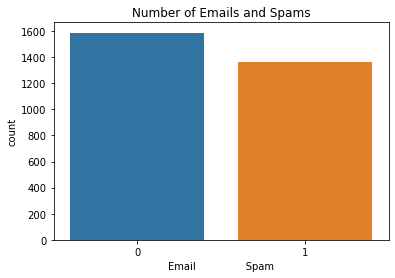

In [5]:
# Display
sns.countplot(Corpus.category)
plt.xlabel('Email                Spam')
plt.title('Number of Emails and Spams')

In [6]:
X = Corpus.email # data
Y = Corpus.category  # labels

In [7]:
# label enconder from pandas to an array
le = LabelEncoder()
Y = le.fit_transform(Y)

# transfor from a array to a vector
Y = Y.reshape(-1,1)

##### Splitting data 70% for training and 30% for testing

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30,random_state=20)

In [9]:
max_words = 1000
max_len = 200
# Tokenize the data and convert the text to sequences.
tok = Tokenizer(num_words=max_words)

#Tokenize the data and convert the text to sequences.
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)

# Add padding to ensure that all the sequences have the same shape.
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# Process the test set data.
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)



### Creating Functional LSTM model

In [10]:
def LSTM_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
# Call the function and compile the model.
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [12]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,validation_split=0.2 )

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1650 samples, validate on 413 samples
Epoch 1/20
1650/1650 [==============================] - 7s 4ms/step - loss: 0.5034 - accuracy: 0.8509 - val_loss: 0.1981 - val_accuracy: 0.9467
Epoch 2/20
1650/1650 [==============================] - 8s 5ms/step - loss: 0.1447 - accuracy: 0.9545 - val_loss: 0.0950 - val_accuracy: 0.9782
Epoch 3/20
1650/1650 [==============================] - 7s 4ms/step - loss: 0.0638 - accuracy: 0.9855 - val_loss: 0.0728 - val_accuracy: 0.9734
Epoch 4/20
1650/1650 [==============================] - 6s 3ms/step - loss: 0.0378 - accuracy: 0.9921 - val_loss: 0.0395 - val_accuracy: 0.9806
Epoch 5/20
1650/1650 [==============================] - 5s 3ms/step - loss: 0.0233 - accuracy: 0.9952 - val_loss: 0.0854 - val_accuracy: 0.9637
Epoch 6/20
1650/1650 [==============================] - 5s 3ms/step - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.0525 - val_accuracy: 0.9758
Epoch 7/20
1650/1650 [==============================] - 5s 3ms/step - loss: 0.0166 - accu

#### Evaluate

In [13]:
# Evaluate the model on the test set.
# Final Result - Generalization!
score = model.evaluate(test_sequences_matrix, Y_test, verbose=1) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

885/885 [==============================] - 1s 2ms/step
Test loss: 0.10684578548058936
Test accuracy: 0.9853107333183289


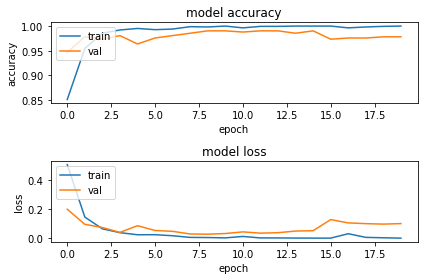

In [14]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.show()

In [15]:
print("{:.2f} seconds".format(time.time() - start_time))

116.91 seconds


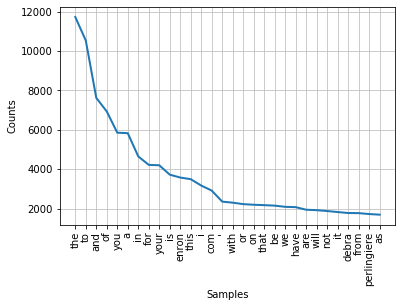

In [16]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import nltk



tokenized_word=[]
fdist = FreqDist()
for i in Corpus.email:
  
    for word in word_tokenize(i):
        fdist[word] += 1
        
fdist.plot(30,cumulative=False)
plt.show()